# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://github.com/Vaeliss/Pokemon_challenge/blob/main/pokemon.csv

Download the `pokemon.csv` file and put it in the file section of Colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.80. Can you beat them?!**

# Imports and dataset

In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import copy

In [407]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [408]:
data = pd.read_csv('pokemon.csv')

In [409]:
data

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,1025,Pecharunt,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,1024,Terapagos,9,Normal,NaN,0.2,6.5,90,65,85,65,85,60,450,1
2,1023,Iron Crown,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,1021,Raging Bolt,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5,Charmeleon,1,Fire,NaN,1.1,19.0,58,64,58,80,65,80,405,0
1021,4,Charmander,1,Fire,NaN,0.6,8.5,39,52,43,60,50,65,309,0
1022,3,Venusaur,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,2,Ivysaur,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


In [410]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [411]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dexnum      1025 non-null   int64  
 1   name        1025 non-null   object 
 2   generation  1025 non-null   int64  
 3   type1       1025 non-null   object 
 4   type2       526 non-null    object 
 5   height      1025 non-null   float64
 6   weight      1025 non-null   float64
 7   hp          1025 non-null   int64  
 8   attack      1025 non-null   int64  
 9   defense     1025 non-null   int64  
 10  sp_atk      1025 non-null   int64  
 11  sp_def      1025 non-null   int64  
 12  speed       1025 non-null   int64  
 13  total       1025 non-null   int64  
 14  legendary   1025 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 120.2+ KB


In [412]:
data.isna().sum()

dexnum          0
name            0
generation      0
type1           0
type2         499
height          0
weight          0
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
total           0
legendary       0
dtype: int64

In [413]:
data = data.drop(['dexnum', 'name', 'type2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [414]:
data['legendary'] = data['legendary'].astype(int)
data['generation'] = data['generation'].astype(str)

In [415]:
data.dtypes

generation     object
type1          object
height        float64
weight        float64
hp              int64
attack          int64
defense         int64
sp_atk          int64
sp_def          int64
speed           int64
total           int64
legendary       int64
dtype: object

Categorical variables are one-hot encoded

In [416]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [417]:
data = onehot_encode(data, 'type1', 't')
data = onehot_encode(data, 'generation', 'g')

In [418]:
data.shape

(1025, 37)

In [419]:
data

,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary,...,t_Water,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9
0,0.3,0.3,88,88,160,88,88,88,600,1,...,False,False,False,False,False,False,False,False,False,True
1,0.2,6.5,90,65,85,65,85,60,450,1,...,False,False,False,False,False,False,False,False,False,True
2,1.6,156.0,90,72,100,122,108,98,590,0,...,False,False,False,False,False,False,False,False,False,True
3,1.5,162.5,90,120,80,68,108,124,590,0,...,False,False,False,False,False,False,False,False,False,True
4,5.2,480.0,125,73,91,137,89,75,590,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1.1,19.0,58,64,58,80,65,80,405,0,...,False,True,False,False,False,False,False,False,False,False
1021,0.6,8.5,39,52,43,60,50,65,309,0,...,False,True,False,False,False,False,False,False,False,False
1022,2.0,100.0,80,82,83,100,100,80,525,0,...,False,True,False,False,False,False,False,False,False,False
1023,1.0,13.0,60,62,63,80,80,60,405,0,...,False,True,False,False,False,False,False,False,False,False


## Splitting and Scaling

In [420]:
data.columns # note that only the first 9 features are continuous now

Index(['height', 'weight', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def',
       'speed', 'total', 'legendary', 't_Bug', 't_Dark', 't_Dragon',
       't_Electric', 't_Fairy', 't_Fighting', 't_Fire', 't_Flying', 't_Ghost',
       't_Grass', 't_Ground', 't_Ice', 't_Normal', 't_Poison', 't_Psychic',
       't_Rock', 't_Steel', 't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5',
       'g_6', 'g_7', 'g_8', 'g_9'],
      dtype='object')

In [421]:
y = data['legendary']
X = data.drop('legendary', axis=1)

In [422]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:9])
X = np.concatenate((X_scaled, np.array(X.iloc[:,9:])), axis=1)

# Model definition

In [423]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
print(f"Using {DEVICE} device")

Using cuda device


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [424]:
import torch.nn.functional as F
class RegModel(nn.Module):
    def __init__(self, input_size, d_1, d_2, p=0.3):  # Increased dropout rate
        super(RegModel, self).__init__()
        self.fc1 = nn.Linear(input_size, d_1)
        self.BN = nn.BatchNorm1d(d_1)
        self.fc2 = nn.Linear(d_1, d_2)
        self.dropout = nn.Dropout(p)
        self.fc3 = nn.Linear(d_2, 1)  # Output a single value

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.BN(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Apply sigmoid to get probability


Instantiate your model and print it out

In [425]:
# Convert DataFrame to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  

In [426]:
input_dime = 36
d_1 = input_dime // 2
d_2 = d_1 // 2

In [427]:
model = RegModel(input_dime, d_1, d_2).to(DEVICE)
model

RegModel(
  (fc1): Linear(in_features=36, out_features=18, bias=True)
  (BN): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=9, out_features=1, bias=True)
)

### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [428]:
lr = 0.001
batch_size = 128
num_epochs = 1000
l1_lambda  = 0.001  

### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [429]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the loss function
loss_fn = nn.BCELoss()
# Define the optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
# Using ReduceLROnPlateau to adjust the learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=20)



Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.
TensorDataset è un modo per "impacchettare" i tuoi tensori di input e target in un unico oggetto.
DataLoader è uno strumento che aiuta a dividere il tuo dataset in piccoli batch di dati e li carica durante l'addestramento in modo efficiente.


In [430]:
# First split: separate test set (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Convert training data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# Convert validation data to tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDataset for all sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for all sets
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [431]:
# Keep track of training and validation losses during training

train_loss_list = []
valid_loss_list = []

train_length = len(trainloader)
valid_length = len(validloader)
valid_length = len(testloader)

# Training

Implement your training and evaluation (for the validation set) loops

In [432]:
for epoch in range(num_epochs):
    for data, target in trainloader:
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        data = data.reshape(-1, input_dime)
        target = target.float().unsqueeze(1)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
    train_loss_list.append(train_loss)

    # Validation loop
    model.eval()
    validation_losses = []
    with torch.no_grad():
        for data, target in validloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data = data.reshape(-1, input_dime)
            target = target.float().unsqueeze(1)
            output = model(data)
            val_loss = loss_fn(output, target).item()
            validation_losses.append(val_loss)

    validation_loss = sum(validation_losses) / len(validation_losses)
    valid_loss_list.append(validation_loss)
    scheduler.step(validation_loss)
    print(f"Epoch {epoch + 1}: Train loss: {train_loss:.4f}, Validation loss: {validation_loss:.4f}")

# Test loop
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        data = data.reshape(-1, input_dime)
        target = target.float().unsqueeze(1)
        outputs = model(data)
        predicted = (outputs >= 0.5).float()
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

        # Collect all predictions and targets
        all_predictions.append(predicted)
        all_targets.append(target)

    acc = 100.0 * n_correct / n_samples
    print("Accuracy on the test set:", acc, "%")

# Concatenate all predictions and targets
all_predictions = torch.cat(all_predictions)
all_targets = torch.cat(all_targets)

Epoch 1: Train loss: 0.7206, Validation loss: 0.6705


Epoch 2: Train loss: 0.6479, Validation loss: 0.6374
Epoch 3: Train loss: 0.5428, Validation loss: 0.5887
Epoch 4: Train loss: 0.5186, Validation loss: 0.5256
Epoch 5: Train loss: 0.4706, Validation loss: 0.4581
Epoch 6: Train loss: 0.3932, Validation loss: 0.3955
Epoch 7: Train loss: 0.3591, Validation loss: 0.3431
Epoch 8: Train loss: 0.2901, Validation loss: 0.3025
Epoch 9: Train loss: 0.2655, Validation loss: 0.2723
Epoch 10: Train loss: 0.3744, Validation loss: 0.2465
Epoch 11: Train loss: 0.2975, Validation loss: 0.2258
Epoch 12: Train loss: 0.2559, Validation loss: 0.2083
Epoch 13: Train loss: 0.2536, Validation loss: 0.1975
Epoch 14: Train loss: 0.2944, Validation loss: 0.1924
Epoch 15: Train loss: 0.2233, Validation loss: 0.1959
Epoch 16: Train loss: 0.1972, Validation loss: 0.1920
Epoch 17: Train loss: 0.2680, Validation loss: 0.1834
Epoch 18: Train loss: 0.2789, Validation loss: 0.1792
Epoch 19: Train loss: 0.2115, Validation loss: 0.1761
Epoch 20: Train loss: 0.1907, Valida

# Results

### Plotting

Plot out the training and validation losses over the epochs

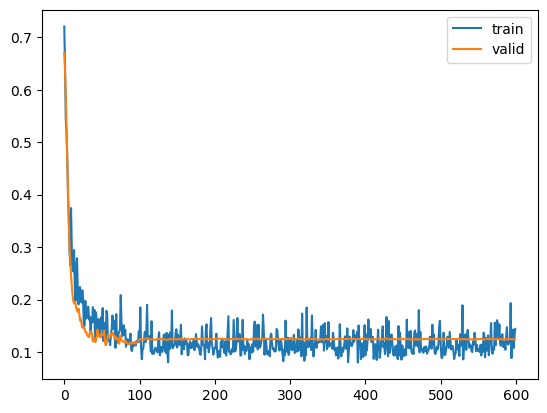

In [433]:
plt.plot(range(num_epochs), train_loss_list, label='train')
plt.plot(range(num_epochs), valid_loss_list, label='valid')
plt.legend(loc="best")
plt.show()

### Metrics

Print out appropriate metrics for the task

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

# Calculate evaluation metrics
accuracy = (all_predictions == all_targets).float().mean().item()
conf_matrix = confusion_matrix(all_targets.cpu().numpy(), all_predictions.cpu().numpy())
f1 = fbeta_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy(), beta=1)
f2 = fbeta_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy(), beta=2)

# Print results
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nDetailed Classification Report:")
print(classification_report(all_targets.cpu().numpy(), all_predictions.cpu().numpy()))


Model Evaluation Metrics:
Accuracy: 0.9512
F1 Score: 0.7368
F2 Score: 0.7143

Confusion Matrix:
[[181   4]
 [  6  14]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       185
         1.0       0.78      0.70      0.74        20

    accuracy                           0.95       205
   macro avg       0.87      0.84      0.85       205
weighted avg       0.95      0.95      0.95       205



In [405]:
# wrong_predictions = # OPTIONAL TODO

  Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements and updates) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).